# Nearest Neighbors
[sklearn.neighbors](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.neighbors) provides functionality for unsupervised and supervised neighbors-based learning methods. Supervised neighbors-based learning comes in two flavors: classification for data with discrete labels, and regression for data with continuous labels.

The principle behind nearest neighbor methods is to find a predefined number of training samples closest in distance to the new point, and predict the label from these. The number of samples can be a user-defined constant (k-nearest neighbor learning), or vary based on the local density of points (radius-based neighbor learning). The distance can, in general, be any metric measure: standard Euclidean distance is the most common choice. Neighbors-based methods are known as *non-generalizing* machine learning methods, since they simply “remember” all of its training data (possibly transformed into a fast indexing structure such as a Ball Tree or KD Tree.).

Despite its simplicity, nearest neighbors has been successful in a large number of classification and regression problems, including handwritten digits or satellite image scenes. Being a non-parametric method, it is often successful in classification situations where the decision boundary is very irregular.

## Nearest Neighbors Classification
Neighbors-based classification is a type of *instance-based learning* or *non-generalizing learning*: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

scikit-learn implements two different nearest neighbors classifiers: [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) implements learning based on the  k nearest neighbors of each query point, where k is an integer value specified by the user. [RadiusNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.RadiusNeighborsClassifier.html#sklearn.neighbors.RadiusNeighborsClassifier) implements learning based on the number of neighbors within a fixed radius r of each training point, where r is a floating-point value specified by the user.

The k-neighbors classification in **KNeighborsClassifier** is the more commonly used of the two techniques. The optimal choice of the value k is highly data-dependent: in general a larger k suppresses the effects of noise, but makes the classification boundaries less distinct.

## Advantages of k-Nearest Neighbors
* Easy to understand
* Fastest learning algorithm
    * Building this model only consists of storing the training set
* Often gives reasonable performance without a lot of adjustments

## Disadvantages of k-Nearest Neighbors
* When your training set is very large (either in number of features or in number of samples) prediction can be slow 
* Important to preprocess your data
    * A funamental assumption of kNN is that all dimensions are "equal", so scales should be similar.
* Does not perform well on datasets with many features
    * Curse of Dimensionality
* Does particularly badly with datasets where most features are 0 most of the time (so-called *sparse datasets*)

*Disclaimer*: Some of the code in this notebook was lifted from the excellent book [Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do) by Andreas Muller and Sarah Guido.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### A First Application: Classifying iris species
One of the most famous datasets for classification in a supervised learning setting is the [Iris flower data set](https://en.wikipedia.org/wiki/Iris_flower_data_set).  It is a multivariate dataset introduced in a 1936 paper which records sepal length, sepal width, petal length, and petal width for three species of iris.

scikit-learn has a number of small toy datasets included with it which makes it quick and easy to experiment with different machine learning algorithms on these datasets.

The [sklearn.datasets.load_iris()](http://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_iris.html#sklearn.datasets.load_iris) method can be used to load the iris dataset.

#### Meet the data
The *iris* object that is returned by **load_iris** is a **Bunch** object, which is very similar to a dictionary.  It contains keys and values.

In [2]:
from sklearn.datasets import load_iris
iris_dataset = load_iris()

In [3]:
print("Keys of iris_dataset: {}".format(iris_dataset.keys()))

Keys of iris_dataset: dict_keys(['target', 'data', 'target_names', 'feature_names', 'DESCR'])


In [4]:
# The value of the key DESCR is a short description of the dataset.  Here we show the beinning of the description.
print(iris_dataset['DESCR'][:193] + "\n...")

Iris Plants Database

Notes
-----
Data Set Characteristics:
    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive att
...


In [5]:
# The value of the key target_names is an array of strings, containing the species of flower that we want to predict
print("Target names: {}".format(iris_dataset['target_names']))

Target names: ['setosa' 'versicolor' 'virginica']


In [6]:
# The value of feature_names is a list of strings, giving the description of each feature
print("Feature names: {}".format(iris_dataset['feature_names']))

Feature names: ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']


In [7]:
# The data itself is contained in the target and data fields.
# data contains the numeric measurements of sepal length, sepal width, petal length, and petal width in a NumPy array
print("Type of data: {}".format(type(iris_dataset['data'])))

Type of data: <class 'numpy.ndarray'>


In [8]:
# The rows in the data array correspond to flowers, while the columns represent the four measurements for each flower.
print("Shape of data: {}".format(iris_dataset['data'].shape))

Shape of data: (150, 4)


In [9]:
# We see that the array contains measurements for 150 different flowers (samples).  Here are values for the first 5.
print("First five columns of data:\n{}".format(iris_dataset['data'][:5]))

First five columns of data:
[[ 5.1  3.5  1.4  0.2]
 [ 4.9  3.   1.4  0.2]
 [ 4.7  3.2  1.3  0.2]
 [ 4.6  3.1  1.5  0.2]
 [ 5.   3.6  1.4  0.2]]


In [10]:
# The target array contains the species of each of the flowers that were measured, also as a NumPy array
print("Type of target: {}".format(type(iris_dataset['target'])))

Type of target: <class 'numpy.ndarray'>


In [11]:
# target is a one-dimensional array, with one entry per flower
print("Shape of target: {}".format(iris_dataset['target'].shape))

Shape of target: (150,)


In [12]:
# The species are encoded as integers from 0 to 2.  The meanings of the numbers are given by the target_names key.
print("Target:\n{}".format(iris_dataset['target']))

Target:
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


#### Measuring Success: Training and testing data
We want to build a machine learning model from this data that can predict the species of iris for a new set of measurements.  But before we can apply our model to new measurements, we need to know whether it actually works -- that is, whether we should trust its predictions.

Unfortunately, we cannot use the data we used to build the model to evaluate it.  This is because our model can always simply remember the whole training set, and will therefore always predict the correct label for any point in the training set.  This "remembering" does not indicate to us whether the model will *generalize* well (in other words, whether it will also perform well on new data).

To assess the model's performance, we show it new data (data that it hasn't seen before) for which we have labels.  This is usually done by splitting the labeled data we have collected (here, our 150 flower measurements) into two parts.  One part of the data is used to build our machine learning model, and is called the *training data* or *training set*.  The rest of the data will be used to assess how well the model works; this is called the *test data*, *test set*, or *hold-out set*.

scikit-learn contains a function that shuffles the dataset and splits it for you:  the [train_test_split](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function.  This function extracts 75% of the rows in the data as the training set, together with the corresponding labels for this data.  The remaining 25% of the data, together with the remaining labels, is declared as the test set.  Deciding how much data you want to put into the training and the test set respectively is somewhat arbitrary, but scikit-learn's default 75/25 split is a reasonable starting point.

In scikit-learn, data is usually denoted with a capital X, while labels are denoted by a lowercase y.  This is inspired by the standard formulation *f(x)=y* in mathematics, where *x* is the input to a function and *y* is the output.  Following more conventions from mathematics, we use a capital *X* because the data is a two-dimensional array (a matrix) and a lowercase *y* because the target is a one-dimensional array (a vector).

Before making the split, the **train_test_split** function shuffles the dataset using a pseudorandom number generator.  If we just took the last 25% of the data as a test set, all the data points would have the label 2, as the data points are sorted by the label.

To make sure this example code will always get the same output if run multiple times, we provide the pseudorandom number generator with a fixed seed using the **random_state** parameter.

The output of the **train_test_split** function is **X_train**, **X_test**, **y_train**, and **y_test**, which are all NumPy arrays.  **X_train** contains 75% of the rows of the dataset, and **X_test** contains the remaining 25%.

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris_dataset['data'], iris_dataset['target'], random_state=0)

In [14]:
print("X_train shape: {}".format(X_train.shape))
print("y_train shape: {}".format(y_train.shape))

X_train shape: (112, 4)
y_train shape: (112,)


In [15]:
print("X_test shape: {}".format(X_test.shape))
print("y_test shape: {}".format(y_test.shape))

X_test shape: (38, 4)
y_test shape: (38,)


#### First things first: Look at your data
Before building a machine learning model, it is often a good idea to inspect the data, to see if the task is easily solvable without machine learning, or if the desired information might not be contained in the data.

Additionally, inspecting the data is a good way to find abnormalities and peculiarities.  Maybe some of your irises were measured using inches and not centimeters, for example.  In the real world, inconsistencies in the data and unexpected measurements are very common, as are missing data and not-a-number (NaN) or infinite values.

One of the best ways to inspect data is to visualize it. One way to do this is by using a *scatter plot*.  A scatter plot of the data puts one feature along the x-axis and another along the y-axis, and draws a dot for each data point.  Unfortunately, computer screens have only two dimensions, which allows us to plot only two (or maybe three) features at a time.  It is difficult to plot datasets with more than three features this way.  One way around this problem is to do a *pair plot*, which looks at all possible pairs of features.  If you have a small number of features, such as the four we have here, this is quite reasonable.  You should keep in mind, however, that a pair plot does not show the interaction of all of the features at once, so some interesting aspects of the data may not be revealed when visualizing it this way.

In Python, the *pandas* library has a convenient function called [scatter_matrix](http://pandas.pydata.org/pandas-docs/version/0.18.1/visualization.html#scatter-matrix-plot) for creating pair plots for a DataFrame.

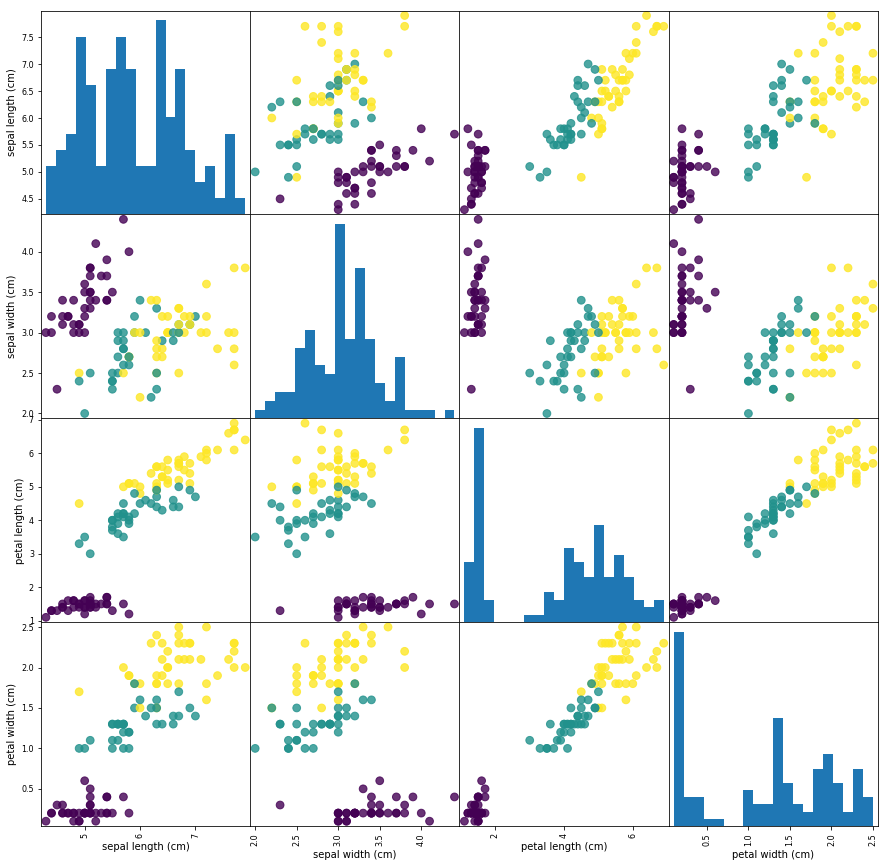

In [16]:
# create dataframe from data in X_train
# label the columns using the strings in iris_dataset.feature_names
iris_dataframe = pd.DataFrame(X_train, columns=iris_dataset.feature_names)
# create a scatter matrix from the dataframe, color by y_train
grr = pd.scatter_matrix(iris_dataframe, c=y_train, figsize=(15, 15), marker='o',
                        hist_kwds={'bins': 20}, s=60, alpha=.8)

From the plots, we can see that the three classes seem to be relatively well separated using the sepal and petal measurements.  This means that a machine learning model will likely be able to learn to separate them quite well.

#### Building your model: k-Nearest Neighbors
Now we can start building the actual machine learning model.  There are many classification algorithms in *scikit-learn* that we could use.  Here we will use a k-nearest neighbors classifier, which is easy to understand.

The k in k-nearest neighbors signifies that instead of using only the closest neighbor to the new data point, we can consider any fixed number k of neighbors in the training (for example, the closest three or five neighbors). Then, we can make a prediction using the majority class among these neighbors. For starters, we’ll use only a single neighbor.

All machine learning models in *scikit-learn* are implemented in their own classes, which are called *Estimator* classes.  The k-nearest neighbors classification algorithm is implemented in the [KNeighborsClassifier](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier) class in the *neighbors* module.  Before we can use the model, we need to instantiate the class into an object.  This is when we will set any parameters of the model.  The most important parameter of KNeighborsClassifier is **n_neighbors **, the number of neighbors, which we will set to 1. The default value for **n_neighbors** is 5.

In [18]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)

The *knn* object encapsulates the algorithm that will be used to build the model from the training data, as well the algorithm to make predictions on new data points.  It will also hold the information that the algorithm has extracted from the training data.  In the case of **KNeighborsClassifier**, it will just store the training set.

To build the model on the training set, we call the **fit** method of the *tree* object, which takes as arguments the NumPy array *X_train* containing the training data and the NumPy array *y_train* of the corresponding training labels.

In [19]:
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=1, p=2,
           weights='uniform')

#### Making predictions
We can now make predictions using this model on new data for which we might not know the correct labels.  Image we found an iris in the wild with a sepal length of 5 cm, a sepal width of 2.9 cm, a petal length of 1 cm, and a petal width of 0.2cm.  What species of iris would this be?  We can put this data into a NumPy array, which in this case will be of shape 1 x 4 (1 row/sample x 4 features).

Note: Even though we made the measurements of this single flower, *scikit-learn* always expects two-dimensional arrays for the data.

To make a prediction, we call the **predict** method of the tree object.

In [20]:
X_new = np.array([[5, 2.9, 1, 0.2]])
print("X_new.shape: {}".format(X_new.shape))

X_new.shape: (1, 4)


In [21]:
prediction = knn.predict(X_new)
print("Prediction: {}".format(prediction))
print("Predicted target name: {}".format(iris_dataset['target_names'][prediction]))

Prediction: [0]
Predicted target name: ['setosa']


#### Evaluating the model
How do we know whether we can trust our model?  This is where the test set that we created earlier comes in.  This data was not used to build the model, but we do know what the correct speciies is for each iris in the test set.

Therefore, we can make a prediction for each iris in the test data and compare it against its lable (the known species).  We can measure how well the model works by computing the *accuracy*, which is the fraction of flowers for which the right species was predicted.

We can also use the **score** method of the tree object, which will compute the test set accuracy for us.

In [22]:
y_pred = knn.predict(X_test)
print("Test set predictions:\n {}".format(y_pred))

Test set predictions:
 [2 1 0 2 0 2 0 1 1 1 2 1 1 1 1 0 1 1 0 0 2 1 0 0 2 0 0 1 1 0 2 1 0 2 2 1 0
 2]


In [23]:
print("Test set score: {:.2f}".format(np.mean(y_pred == y_test)))

Test set score: 0.97


In [25]:
print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 0.97


For this model, the test set accuracy is about 0.97, which means we made the right prediction for 97% of the irises in the test set.  Under some mathematical assumptions, this means that we can expect our model to be correct about 97% of the time for new irises.  

A more advanced model may be able to do a better job, but with an overlapping dataset like this, it is unlikely that we would ever be able to achieve 100% accuracy.

#### Summary
Here is a summary of the code needed for the whole training and evaluation procedure (just 4 lines!).

This snippet contains the core code for applying any machine learning algorithm using *scikit-learn*.  The **fit**, **predict**, and **score** methods are the common interface to supervised models in *scikit-learn*.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(iris_dataset['data'], iris_dataset['target'], random_state=0)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

print("Test set score: {:.2f}".format(knn.score(X_test, y_test)))

Test set score: 0.97


# Effect of k
Let's Investigate the effect of varying k.  But the iris dataset isn't the ideal dataset for this purpose.  So let's create a synthetic dataset which this would be good for.

In [31]:
import numbers
import numpy as np

from sklearn.utils import check_array, check_random_state
from sklearn.utils import shuffle as shuffle_


def make_blobs(n_samples=100, n_features=2, centers=2, cluster_std=1.0,
               center_box=(-10.0, 10.0), shuffle=True, random_state=None):
    """Generate isotropic Gaussian blobs for clustering.

    Read more in the :ref:`User Guide <sample_generators>`.

    Parameters
    ----------
    n_samples : int, or tuple, optional (default=100)
        The total number of points equally divided among clusters.

    n_features : int, optional (default=2)
        The number of features for each sample.

    centers : int or array of shape [n_centers, n_features], optional
        (default=3)
        The number of centers to generate, or the fixed center locations.

    cluster_std: float or sequence of floats, optional (default=1.0)
        The standard deviation of the clusters.

    center_box: pair of floats (min, max), optional (default=(-10.0, 10.0))
        The bounding box for each cluster center when centers are
        generated at random.

    shuffle : boolean, optional (default=True)
        Shuffle the samples.

    random_state : int, RandomState instance or None, optional (default=None)
        If int, random_state is the seed used by the random number generator;
        If RandomState instance, random_state is the random number generator;
        If None, the random number generator is the RandomState instance used
        by `np.random`.

    Returns
    -------
    X : array of shape [n_samples, n_features]
        The generated samples.

    y : array of shape [n_samples]
        The integer labels for cluster membership of each sample.

    Examples
    --------
    >>> from sklearn.datasets.samples_generator import make_blobs
    >>> X, y = make_blobs(n_samples=10, centers=3, n_features=2,
    ...                   random_state=0)
    >>> print(X.shape)
    (10, 2)
    >>> y
    array([0, 0, 1, 0, 2, 2, 2, 1, 1, 0])

    See also
    --------
    make_classification: a more intricate variant
    """
    generator = check_random_state(random_state)

    if isinstance(centers, numbers.Integral):
        centers = generator.uniform(center_box[0], center_box[1],
                                    size=(centers, n_features))
    else:
        centers = check_array(centers)
        n_features = centers.shape[1]

    if isinstance(cluster_std, numbers.Real):
        cluster_std = np.ones(len(centers)) * cluster_std

    X = []
    y = []

    n_centers = centers.shape[0]
    if isinstance(n_samples, numbers.Integral):
        n_samples_per_center = [int(n_samples // n_centers)] * n_centers
        for i in range(n_samples % n_centers):
            n_samples_per_center[i] += 1
    else:
        n_samples_per_center = n_samples

    for i, (n, std) in enumerate(zip(n_samples_per_center, cluster_std)):
        X.append(centers[i] + generator.normal(scale=std,
                                               size=(n, n_features)))
        y += [i] * n

    X = np.concatenate(X)
    y = np.array(y)

    if shuffle:
        X, y = shuffle_(X, y, random_state=generator)

    return X, y

In [32]:
def make_forge():
    # a carefully hand-designed dataset lol
    X, y = make_blobs(centers=2, random_state=4, n_samples=30)
    y[np.array([7, 27])] = 0
    mask = np.ones(len(X), dtype=np.bool)
    mask[np.array([0, 1, 5, 26])] = 0
    X, y = X[mask], y[mask]
    return X, y

In [57]:
from sklearn.model_selection import train_test_split
X, y = make_forge()
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [41]:
import matplotlib as mpl
from matplotlib.colors import colorConverter

def discrete_scatter(x1, x2, y=None, markers=None, s=10, ax=None,
                     labels=None, padding=.2, alpha=1, c=None, markeredgewidth=None):
    """Adaption of matplotlib.pyplot.scatter to plot classes or clusters.

    Parameters
    ----------

    x1 : nd-array
        input data, first axis

    x2 : nd-array
        input data, second axis

    y : nd-array
        input data, discrete labels

    cmap : colormap
        Colormap to use.

    markers : list of string
        List of markers to use, or None (which defaults to 'o').

    s : int or float
        Size of the marker

    padding : float
        Fraction of the dataset range to use for padding the axes.

    alpha : float
        Alpha value for all points.
    """
    if ax is None:
        ax = plt.gca()

    if y is None:
        y = np.zeros(len(x1))

    unique_y = np.unique(y)

    if markers is None:
        markers = ['o', '^', 'v', 'D', 's', '*', 'p', 'h', 'H', '8', '<', '>'] * 10

    if len(markers) == 1:
        markers = markers * len(unique_y)

    if labels is None:
        labels = unique_y

    # lines in the matplotlib sense, not actual lines
    lines = []

    current_cycler = mpl.rcParams['axes.prop_cycle']

    for i, (yy, cycle) in enumerate(zip(unique_y, current_cycler())):
        mask = y == yy
        # if c is none, use color cycle
        if c is None:
            color = cycle['color']
        elif len(c) > 1:
            color = c[i]
        else:
            color = c
        # use light edge for dark markers
        if np.mean(colorConverter.to_rgb(color)) < .4:
            markeredgecolor = "grey"
        else:
            markeredgecolor = "black"

        lines.append(ax.plot(x1[mask], x2[mask], markers[i], markersize=s,
                             label=labels[i], alpha=alpha, c=color,
                             markeredgewidth=markeredgewidth,
                             markeredgecolor=markeredgecolor)[0])

    if padding != 0:
        pad1 = x1.std() * padding
        pad2 = x2.std() * padding
        xlim = ax.get_xlim()
        ylim = ax.get_ylim()
        ax.set_xlim(min(x1.min() - pad1, xlim[0]), max(x1.max() + pad1, xlim[1]))
        ax.set_ylim(min(x2.min() - pad2, ylim[0]), max(x2.max() + pad2, ylim[1]))

    return lines

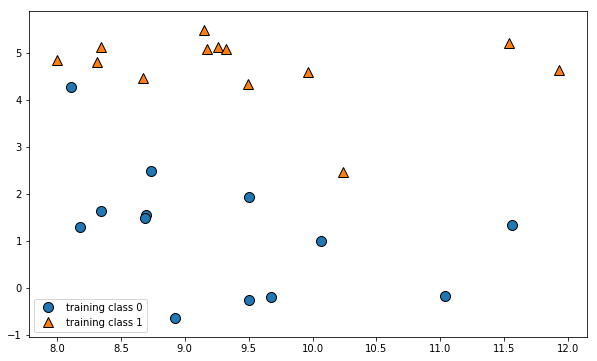

In [46]:
plt.figure(figsize=(10,6))
discrete_scatter(X[:, 0], X[:, 1], y)
plt.legend(["training class 0", "training class 1"])

In [50]:
from sklearn.metrics import euclidean_distances

def plot_knn_classification(n_neighbors=1):
    X, y = make_forge()

    X_test = np.array([[8.2, 3.66214339], [9.9, 3.2], [11.2, .5]])
    dist = euclidean_distances(X, X_test)
    closest = np.argsort(dist, axis=0)

    for x, neighbors in zip(X_test, closest.T):
        for neighbor in neighbors[:n_neighbors]:
            plt.arrow(x[0], x[1], X[neighbor, 0] - x[0],
                      X[neighbor, 1] - x[1], head_width=0, fc='k', ec='k')

    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    test_points = discrete_scatter(X_test[:, 0], X_test[:, 1], clf.predict(X_test), markers="*")
    training_points = discrete_scatter(X[:, 0], X[:, 1], y)
    plt.legend(training_points + test_points, ["training class 0", "training class 1",
                                               "test pred 0", "test pred 1"])

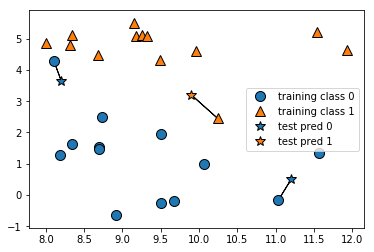

In [51]:
# k = 1
plot_knn_classification(n_neighbors=1)

Here, we added three new data points, shown as stars. For each of them, we marked the closest point in the training set. The prediction of the one-nearest-neighbor algorithm is the label of that point (shown by the color of the cross).

Instead of considering only the closest neighbor, we can also consider an arbitrary number, k, of neighbors. This is where the name of the k-nearest neighbors algorithm comes from. When considering more than one neighbor, we use voting to assign a label. This means that for each test point, we count how many neighbors belong to class 0 and how many neighbors belong to class 1. We then assign the class that is more frequent: in other words, the majority class among the k-nearest neighbors. The following example uses the three closest neighbors.

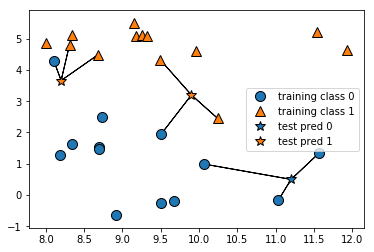

In [52]:
# k = 3
plot_knn_classification(n_neighbors=3)

Again, the prediction is shown as the color of the cross. You can see that the prediction for the new data point at the top left is not the same as the prediction when we used only one neighbor.

While this illustration is for a binary classification problem, this method can be applied to datasets with any number of classes. For more classes, we count how many neighbors belong to each class and again predict the most common class.

### Analyzing Decision Boundary as k varies
For two-dimensional datasets, we can also illustrate the prediction for all possible test points in the xy-plane. We color the plane according to the class that would be assigned to a point in this region. This lets us view the *decision boundary*, which is the divide between where the algorithm assigns class 0 versus where it assigns class 1. The following code produces the visualizations of the decision boundaries for one, three, and nine neighbors.

In [61]:
from matplotlib.colors import ListedColormap
cm2 = ListedColormap(['#0000aa', '#ff2020'])

def plot_2d_separator(classifier, X, fill=False, ax=None, eps=None, alpha=1,
                      cm=cm2, linewidth=None, threshold=None, linestyle="solid"):
    # binary?
    if eps is None:
        eps = X.std() / 2.

    if ax is None:
        ax = plt.gca()

    x_min, x_max = X[:, 0].min() - eps, X[:, 0].max() + eps
    y_min, y_max = X[:, 1].min() - eps, X[:, 1].max() + eps
    xx = np.linspace(x_min, x_max, 100)
    yy = np.linspace(y_min, y_max, 100)

    X1, X2 = np.meshgrid(xx, yy)
    X_grid = np.c_[X1.ravel(), X2.ravel()]
    try:
        decision_values = classifier.decision_function(X_grid)
        levels = [0] if threshold is None else [threshold]
        fill_levels = [decision_values.min()] + levels + [decision_values.max()]
    except AttributeError:
        # no decision_function
        decision_values = classifier.predict_proba(X_grid)[:, 1]
        levels = [.5] if threshold is None else [threshold]
        fill_levels = [0] + levels + [1]
    if fill:
        ax.contourf(X1, X2, decision_values.reshape(X1.shape),
                    levels=fill_levels, alpha=alpha, cmap=cm)
    else:
        ax.contour(X1, X2, decision_values.reshape(X1.shape), levels=levels,
                   colors="black", alpha=alpha, linewidths=linewidth,
                   linestyles=linestyle, zorder=5)

    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())


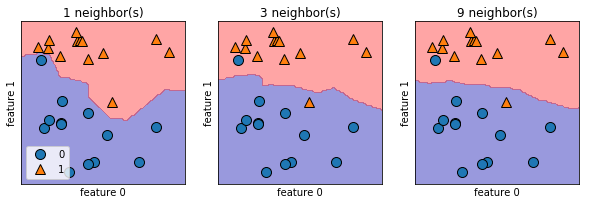

In [62]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3))

for n_neighbors, ax in zip([1, 3, 9], axes):
    # the fit method returns the object self, so we can instantiate
    # and fit in one line
    clf = KNeighborsClassifier(n_neighbors=n_neighbors).fit(X, y)
    plot_2d_separator(clf, X, fill=True, eps=0.5, ax=ax, alpha=.4)
    discrete_scatter(X[:, 0], X[:, 1], y, ax=ax)
    ax.set_title("{} neighbor(s)".format(n_neighbors))
    ax.set_xlabel("feature 0")
    ax.set_ylabel("feature 1")
axes[0].legend(loc=3)

As you can see on the left in the figure, using a single neighbor results in a decision boundary that follows the training data closely. Considering more and more neighbors leads to a smoother decision boundary. A smoother boundary corresponds to a simpler model. In other words, using few neighbors corresponds to high model complexity, and using many neighbors corresponds to low model complexity. If you consider the extreme case where the number of neighbors is the number of all data points in the training set, each test point would have exactly the same neighbors (all training points) and all predictions would be the same: the class that is most frequent in the training set.

Let’s investigate whether we can confirm the connection between model complexity and generalization. We will do this on the real-world Breast Cancer dataset. We begin by splitting the dataset into a training and a test set. Then we evaluate training and test set performance with different numbers of neighbors.

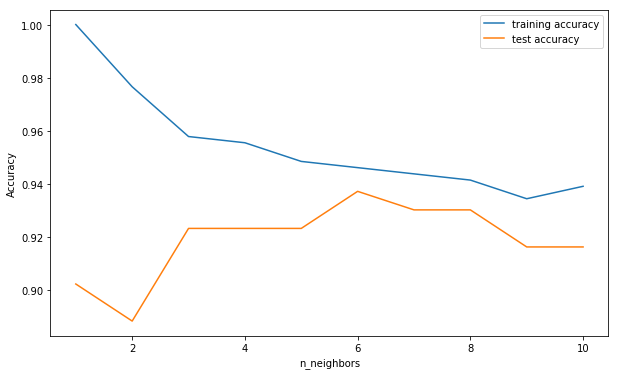

In [64]:
from sklearn.datasets import load_breast_cancer

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data, cancer.target, stratify=cancer.target, random_state=66)

training_accuracy = []
test_accuracy = []
# try n_neighbors from 1 to 10
neighbors_settings = range(1, 11)

for n_neighbors in neighbors_settings:
    # build the model
    clf = KNeighborsClassifier(n_neighbors=n_neighbors)
    clf.fit(X_train, y_train)
    # record training set accuracy
    training_accuracy.append(clf.score(X_train, y_train))
    # record generalization accuracy
    test_accuracy.append(clf.score(X_test, y_test))

plt.figure(figsize=(10,6))
plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

The plot shows the training and test set accuracy on the y-axis against the setting of n_neighbors on the x-axis. While real-world plots are rarely very smooth, we can still recognize some of the characteristics of overfitting and underfitting (note that because considering fewer neighbors corresponds to a more complex model, the plot is horizontally flipped relative to what is conventionally seen. Considering a single nearest neighbor, the prediction on the training set is perfect. But when more neighbors are considered, the model becomes simpler and the training accuracy drops. The test set accuracy for using a single neighbor is lower than when using more neighbors, indicating that using the single nearest neighbor leads to a model that is too complex. On the other hand, when considering 10 neighbors, the model is too simple and performance is even worse. The best performance is somewhere in the middle, using around six neighbors. Still, it is good to keep the scale of the plot in mind. The worst performance is around 88% accuracy, which might still be acceptable.

# Strengths, weaknesses, and parameters of kNN
In principle, there are two important parameters to the KNeighbors classifier: the number of neighbors and how you measure distance between data points. In practice, using a small number of neighbors like three or five often works well, but you should certainly adjust this parameter. Choosing the right distance measure is complicated and in the real world would likely require domain knowledge. By default, Euclidean distance is used, which works well in many settings.

One of the strengths of k-NN is that the model is very easy to understand, and often gives reasonable performance without a lot of adjustments. Using this algorithm is a good baseline method to try before considering more advanced techniques. Building the nearest neighbors model is usually very fast, but when your training set is very large (either in number of features or in number of samples) prediction can be slow. When using the k-NN algorithm, it’s important to preprocess your data (particularly scaling it using either StandardScaler or MinMaxScaler). This approach often does not perform well on datasets with many features (hundreds or more), and it does particularly badly with datasets where most features are 0 most of the time (so-called sparse datasets).

So, while the nearest k-neighbors algorithm is easy to understand, it is not often used in practice, due to prediction being slow and its inability to handle many features.